In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

import statsmodels.api as sm
import statsmodels.tsa.api as smt

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore') 
warnings.simplefilter("ignore", ConvergenceWarning)

## Data Cleaning

In [2]:
df = pd.read_csv('parkingLot.csv', dtype={'camera_id': str}) 

df_entry = df[df['camera_id'] == '001'].sort_values(by='vehicle_no')
df_entry.reset_index(drop = True, inplace = True)
# df_entry.to_csv('parkingLot_camera_001.csv', index=False)

df_exit = df[df['camera_id'] == '002'].sort_values(by='vehicle_no')
df_exit.reset_index(drop = True, inplace = True)
# df_exit.to_csv('parkingLot_camera_002.csv', index=False)

duplicates = df['vehicle_no'].value_counts()[df['vehicle_no'].value_counts()%2 != 0]
print(duplicates.shape[0])


dd3 = pd.DataFrame({
    'vehicle_no': ['MHWW1113', 'MHPY2628', 'MHBK0188', 'MHKA6372', 'MHYV2746', 'MHPH6142', 'MHSM0215', 'MHNO9764', 'MHCZ2221'],
    'timestamp': ['2024-10-19 14:00:00', '2024-11-09 14:00:00', '2024-10-07 14:20:00', '2024-10-26 17:20:00', '2024-11-09 13:00:00', '2024-09-28 14:00:00', '2024-09-30 05:40:00', '2024-09-14 15:20:00', '2024-10-05 17:00:00'],
    'camera_id': ['002', '002', '001', '002', '002', '002', '001', '001', '002']
})

unique_001 = df_entry[~df_entry['vehicle_no'].isin(df_exit['vehicle_no'])].sort_values(by='vehicle_no')
unique_002 = df_exit[~df_exit['vehicle_no'].isin(df_entry['vehicle_no'])].sort_values(by='vehicle_no')
Nan = df[pd.isna(df['vehicle_no'])].sort_values(by='camera_id')
Nan_001 = Nan[Nan['camera_id'] == '001'].sort_values(by = 'timestamp')
Nan_002 = Nan[Nan['camera_id'] == '002'].sort_values(by = 'timestamp')

filtered_dd13 = dd3[dd3['camera_id'] == '001']
updated_camera_001 = pd.concat([unique_001, filtered_dd13], ignore_index=True).sort_values(by='vehicle_no')
filtered_dd23 = dd3[dd3['camera_id'] == '002']
updated_camera_002 = pd.concat([unique_002, filtered_dd23], ignore_index=True).sort_values(by='vehicle_no')


# shape
print(Nan.shape[0])
print(Nan_001.shape[0],Nan_002.shape[0])
print(updated_camera_001.shape[0],updated_camera_002.shape[0])

# Save to new files
updated_camera_001.reset_index(drop=True, inplace=True)
updated_camera_001.reset_index(drop=True, inplace=True)
Nan_001.reset_index(drop=True, inplace=True)
Nan_002.reset_index(drop=True, inplace=True)
Nan.reset_index(drop= True, inplace = True)
# updated_camera_001.to_csv('unique_camera_001.csv', index=False)
# updated_camera_002.to_csv('unique_camera_002.csv', index=False)
# Nan_001.to_csv('Nan_001.csv', index = False)
# Nan_002.to_csv('Nan_002.csv', index = False)
# Nan.to_csv('Unique_NaN.csv', index= False)

1471
441
371 70
585 886


In [3]:
def is_similar(vn1, vn2):
    if len(vn1) != len(vn2):
        return False
    differences = sum(1 for a, b in zip(vn1, vn2) if a != b)
    return differences <= 1


pairs_same = []
paired_v2 = set()
count =0

for v1_row in updated_camera_001.itertuples(index=False):
    v1 = v1_row.vehicle_no
    v1_time = pd.to_datetime(v1_row.timestamp)
    
    for v2_row in updated_camera_002.itertuples(index=False):
        v2 = v2_row.vehicle_no
        v2_time = pd.to_datetime(v2_row.timestamp)
        if is_similar(v1, v2) and v1_time < v2_time:
            if v2 == 'MHOL4368':
                print(v1,v2)
            if v2 not in paired_v2:
                pairs_same.append((v1, v2))
                paired_v2.add(v2)
            break

# Convert pairs to DataFrame for better readability
pairs_df = pd.DataFrame(pairs_same, columns=['vehicle_no_001', 'vehicle_no_002'])

MHOL4378 MHOL4368
MHOV4368 MHOL4368


In [4]:
# Extract the vehicle_no from pairs_df
paired_001 = pairs_df['vehicle_no_001']
paired_002 = pairs_df['vehicle_no_002']

# Create new DataFrames excluding paired vehicle_no
remaining_001 = updated_camera_001[~updated_camera_001['vehicle_no'].isin(paired_001)].sort_values(by='timestamp')
remaining_002 = updated_camera_002[~updated_camera_002['vehicle_no'].isin(paired_002)].sort_values(by='timestamp')

# Save to new CSV files
remaining_002.reset_index(drop=True, inplace=True)
remaining_001.reset_index(drop=True, inplace=True)
# remaining_001.to_csv('remaining_unique_001.csv', index=False)
# remaining_002.to_csv('remaining_unique_002.csv', index=False)
print(remaining_001.shape[0],remaining_002.shape[0])

70 371


In [5]:
# Read the CSV file into a DataFrame
df = pd.read_csv('parkingLot.csv', dtype= {'camera_id' : str})  # Replace with your actual file name

# Sort the DataFrame by 'vehicle_no'
df_sorted = df.sort_values(by='vehicle_no')

# Save the sorted DataFrame to a new CSV file (if needed)
df_sorted.reset_index(drop=True, inplace=True)
# df_sorted.to_csv('sorted_parkingLot.csv', index=False)  # Save the sorted file

In [6]:
                                # Delete a column by position (e.g., delete the 1st column, index 0)
Nan_001_copy = Nan_001.drop(Nan_001.columns[0], axis=1)

# Insert the first column from df2 at the 0th position in df1
Nan_001_copy.insert(0, 'vehicle_no', remaining_002.iloc[:, 0])  # Adding the first column of df2 at position 0

# Save the result to a new CSV file
# Nan_001_copy.to_csv('Nan001_with_vehicle_no.csv', index=False)

In [7]:
q2_001 = df_entry[~df_entry['vehicle_no'].isin(unique_001['vehicle_no'])].sort_values(by='vehicle_no')
q2_002 = df_exit[~df_exit['vehicle_no'].isin(unique_002['vehicle_no'])].sort_values(by='vehicle_no')
q2_001 = q2_001[~q2_001['vehicle_no'].isin(Nan_001['vehicle_no'])].sort_values(by='vehicle_no')
q2_002 = q2_002[~q2_002['vehicle_no'].isin(Nan_002['vehicle_no'])].sort_values(by='vehicle_no')

# Sample data for demonstration (assuming q2_001 and q2_002 are already loaded DataFrames)
vehicle_no = ['MHWW1113', 'MHPY2628', 'MHBK0188', 'MHKA6372', 'MHYV2746', 'MHPH6142', 'MHSM0215', 'MHNO9764', 'MHCZ2221']
timestamp = ['2024-10-19 14:00:00', '2024-11-09 14:00:00', '2024-10-07 14:20:00', '2024-10-26 17:20:00', '2024-11-09 13:00:00', '2024-09-28 14:00:00', '2024-09-30 05:40:00', '2024-09-14 15:20:00', '2024-10-05 17:00:00']
camera_id = ['002', '002', '001', '002', '002', '002', '001', '001', '002']

# Assuming q2_001 and q2_002 are pre-loaded DataFrames that we want to update
for x, y, z in zip(vehicle_no, timestamp, camera_id):
    if z == '001':
        q2_001 = q2_001.query(f"vehicle_no != '{x}' or timestamp != '{y}' or camera_id != '{z}'")
    else:
        q2_002 = q2_002.query(f"vehicle_no != '{x}' or timestamp != '{y}' or camera_id != '{z}'")

print(q2_002.shape[0])
print(q2_001.shape[0])
q2_001.reset_index(drop= True, inplace = True)
# q2_001.to_csv('q2_001.csv', index=False)
q2_002.reset_index(drop= True, inplace = True)
# q2_002.to_csv('q2_002.csv', index=False)

52391
52391


In [8]:
# Convert the timestamp to datetime
q2_001['timestamp'] = pd.to_datetime(q2_001['timestamp'])
q2_002['timestamp'] = pd.to_datetime(q2_002['timestamp'])

# Add suffixes to each column name to distinguish between entry and exit
q2_001 = q2_001.add_suffix('_entry')
q2_002 = q2_002.add_suffix('_exit')

# Concatenate DataFrames row by row
merged_df = pd.concat([q2_001, q2_002], axis=1)

# Print merged DataFrame for verification
print("Merged DataFrame Row by Row:")
# print(merged_df)

# Calculate time spent in seconds
merged_df['time_spent'] = (merged_df['timestamp_exit'] - merged_df['timestamp_entry']).dt.total_seconds()

# Extract the date for grouping
merged_df['date'] = merged_df['timestamp_entry'].dt.date

# Group by date and vehicle_no to calculate the average time spent
average_time_spent = merged_df.groupby(['date'])['time_spent'].mean().reset_index()

# Convert seconds to a more readable format (hours)
average_time_spent['time_spent_hours'] = average_time_spent['time_spent'] / 3600
average_time_spent.set_index('date', inplace=True)
average_time_spent.drop(columns='time_spent',inplace=True)
# Output the result
print("\nAverage Time Spent:")
print(average_time_spent)

Merged DataFrame Row by Row:

Average Time Spent:
            time_spent_hours
date                        
2024-09-12          6.344788
2024-09-13         14.755639
2024-09-14          9.720342
2024-09-15         10.947105
2024-09-16          9.349282
...                      ...
2024-11-09          3.597173
2024-11-10          3.031695
2024-11-11          4.683803
2024-11-12          1.937605
2024-11-13          5.201299

[63 rows x 1 columns]


In [9]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62199D+00    |proj g|=  2.87351D+00

At iterate    5    f=  1.71223D+00    |proj g|=  1.30858D-01


 This problem is unconstrained.



At iterate   10    f=  1.65948D+00    |proj g|=  2.90812D-02

At iterate   15    f=  1.64708D+00    |proj g|=  2.53114D-02

At iterate   20    f=  1.64349D+00    |proj g|=  1.51859D-02

At iterate   25    f=  1.64082D+00    |proj g|=  1.42809D-02

At iterate   30    f=  1.64054D+00    |proj g|=  4.21159D-03

At iterate   35    f=  1.63903D+00    |proj g|=  1.11136D-02

At iterate   40    f=  1.63855D+00    |proj g|=  1.67000D-02

At iterate   45    f=  1.63843D+00    |proj g|=  1.05852D-03

At iterate   50    f=  1.63839D+00    |proj g|=  2.69884D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     58   

 This problem is unconstrained.



At iterate    5    f=  1.66562D+00    |proj g|=  1.55777D-01

At iterate   10    f=  1.61493D+00    |proj g|=  5.37178D-02

At iterate   15    f=  1.59951D+00    |proj g|=  3.98817D-02

At iterate   20    f=  1.58486D+00    |proj g|=  1.44118D-02

At iterate   25    f=  1.58301D+00    |proj g|=  4.07616D-03

At iterate   30    f=  1.58284D+00    |proj g|=  1.13788D-02

At iterate   35    f=  1.58267D+00    |proj g|=  3.06057D-03

At iterate   40    f=  1.58262D+00    |proj g|=  1.55379D-03

At iterate   45    f=  1.58250D+00    |proj g|=  2.92854D-03

At iterate   50    f=  1.58246D+00    |proj g|=  1.69807D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

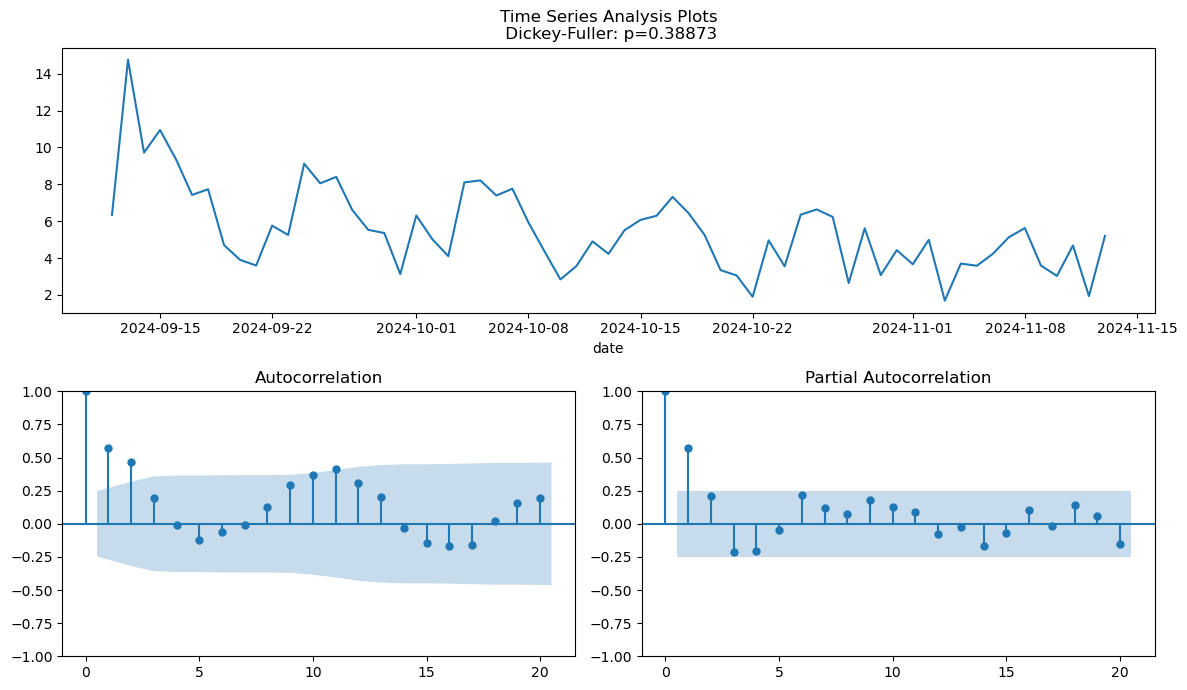

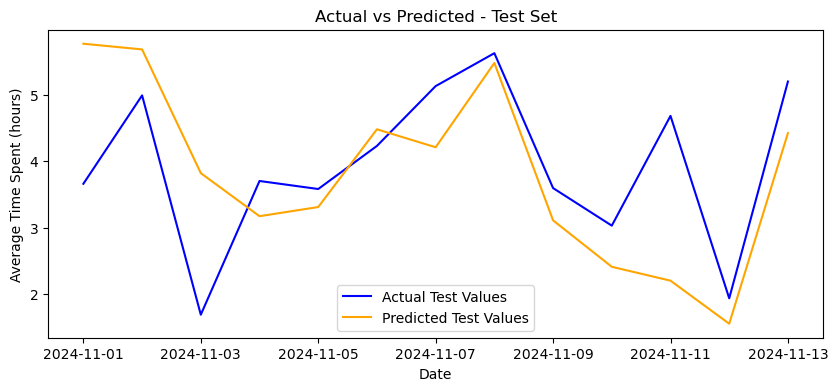

MAPE: 0.28, MASE: 0.55
2024-11-14    1.760212
2024-11-15    3.803824
2024-11-16    3.486030
2024-11-17    4.015187
2024-11-18    1.313905
2024-11-19    4.516868
2024-11-20    3.051363
Freq: D, Name: predicted_mean, dtype: float64


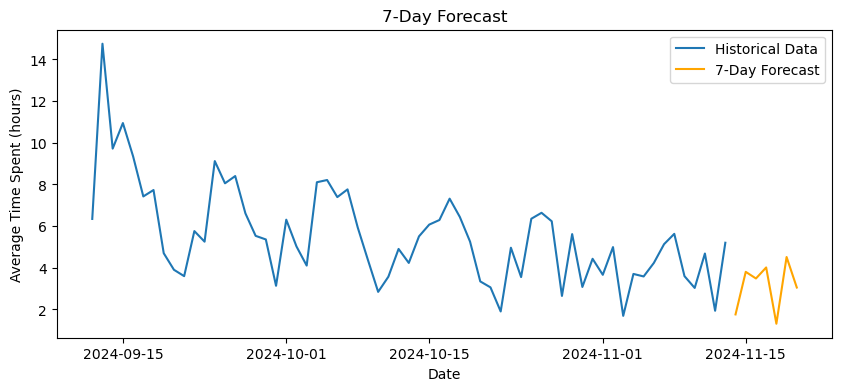

In [10]:
# Plotting the time series, ACF, and PACF
tsplot(average_time_spent['time_spent_hours'], lags=20)

# Split into training and testing sets
train_size_time = int(len(average_time_spent) * 0.8)  # 80% for training
train_time, test_time = average_time_spent.iloc[:train_size_time], average_time_spent.iloc[train_size_time:]

# SARIMAX Model fitting
model_time = SARIMAX(train_time['time_spent_hours'], order=(3, 1, 3), seasonal_order=(2, 1, 5, 7))  # Example parameters
model_fit_time = model_time.fit()

# Model for the full dataset to make future predictions
full_model_time = SARIMAX(average_time_spent['time_spent_hours'], order=(3, 1, 3), seasonal_order=(2, 1, 5, 7))
full_model_fit_time = full_model_time.fit()

# Make predictions for the test set
test_forecast_time = model_fit_time.forecast(steps=len(test_time))

# Plotting forecast vs actual values
plt.figure(figsize=(10, 4))
plt.plot(test_time.index, test_time['time_spent_hours'], label='Actual Test Values', color='blue')
plt.plot(test_time.index, test_forecast_time, label='Predicted Test Values', color='orange')
plt.title('Actual vs Predicted - Test Set')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (hours)')
plt.legend()
plt.show()

# Calculate metrics
mape = mean_absolute_percentage_error(test_time['time_spent_hours'], test_forecast_time)
mase = mean_absolute_error(test_time['time_spent_hours'], test_forecast_time) / np.mean(np.abs(np.diff(train_time['time_spent_hours'])))
print(f'MAPE: {mape:.2f}, MASE: {mase:.2f}')

# Forecast the next 7 days
forecast_steps = 7
future_forecast_time = full_model_fit_time.forecast(steps=forecast_steps)
print(future_forecast_time)

# Prepare the date index for the forecast using the last date in the index
forecast_dates = pd.date_range(start=average_time_spent.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Plot the forecast
plt.figure(figsize=(10, 4))
plt.plot(average_time_spent['time_spent_hours'], label='Historical Data')
plt.plot(forecast_dates, future_forecast_time, label='7-Day Forecast', color='orange')
plt.title('7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (hours)')
plt.legend()
plt.show()